### Synthetic Data Creation with GANs - Porsche Class

In [42]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

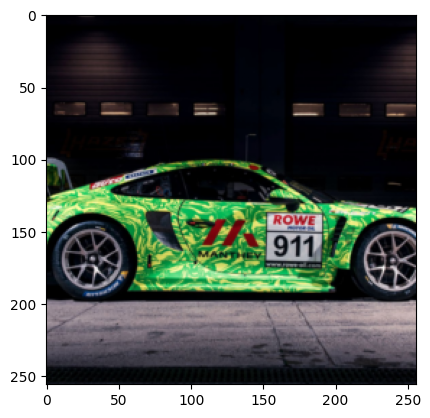

In [16]:
# Synthetic data with DCGan : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Only run this when you dont want to augment the datasets

'''
data_path = "./train_porsche" # made a separate folder with porsche images to produce porsche synthetic data
image_size = 256
batch_size = 64
normstats = (0.,0.,0.),(1.,1.,1.)
transforms = tt.Compose([tt.Resize(image_size),#resize to make things uniform
                        tt.CenterCrop(image_size),#cropping to the center to avoid distortion
                        tt.ToTensor(),#to a tensor
                        tt.Normalize(*normstats)#normalizing in order to increase effectiveness of our GAN
                        ])
dataset = ImageFolder(data_path, transform = transforms)
img, _ = dataset[0]
plt.imshow(img.permute((1,2,0)))
'''


Original dataset size: 1013
Augmented dataset size: 10130


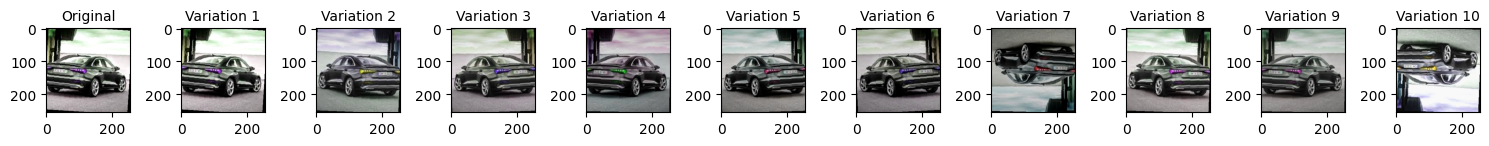

In [60]:
import torch
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

# Define data path and parameters
data_path = "./data_audi"
image_size = 256
normstats = (0., 0., 0.), (1., 1., 1.)
num_variations = 10

# Function to generate random transformations for each sample
def get_transforms():
    return tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.RandomHorizontalFlip(),  # Random horizontal flip
        tt.RandomVerticalFlip(),    # Random vertical flip
        tt.RandomRotation(random.randint(0, 10)),  # Random rotation by up to 10 degrees
        tt.ColorJitter(brightness=random.uniform(0.1, 0.3),  # Random brightness
                       contrast=random.uniform(0.1, 0.3),    # Random contrast
                       saturation=random.uniform(0.1, 0.3),  # Random saturation
                       hue=random.uniform(0.1, 0.4)),      # Random hue
        tt.ToTensor(),
        tt.Normalize(*normstats)
    ])

# Load original dataset
dataset = ImageFolder(data_path)

# Print original dataset size
print("Original dataset size:", len(dataset))

# Augment the dataset by replicating each image with variations
augmented_samples = []
for img, label in dataset:
    # Generate random transformations for each sample
    transforms = get_transforms()
    for _ in range(num_variations):
        augmented_samples.append((transforms(img), label))

# Create augmented dataset
augmented_dataset = torch.utils.data.TensorDataset(torch.stack([sample[0] for sample in augmented_samples]),
                                                   torch.tensor([sample[1] for sample in augmented_samples]))

# Print augmented dataset size
print("Augmented dataset size:", len(augmented_dataset))

# Select a random image and its variations from the augmented dataset
selected_index = random.randint(0, len(augmented_dataset) - 1)
img, _ = augmented_dataset[selected_index]

# Display the original image and its variations
plt.figure(figsize=(15, 3))
plt.subplot(1, num_variations + 1, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Original", fontsize=10)
for i in range(num_variations):
    img, _ = augmented_dataset[selected_index + i]
    plt.subplot(1, num_variations + 1, i + 2)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Variation {i + 1}", fontsize=10)
plt.tight_layout()
plt.show()


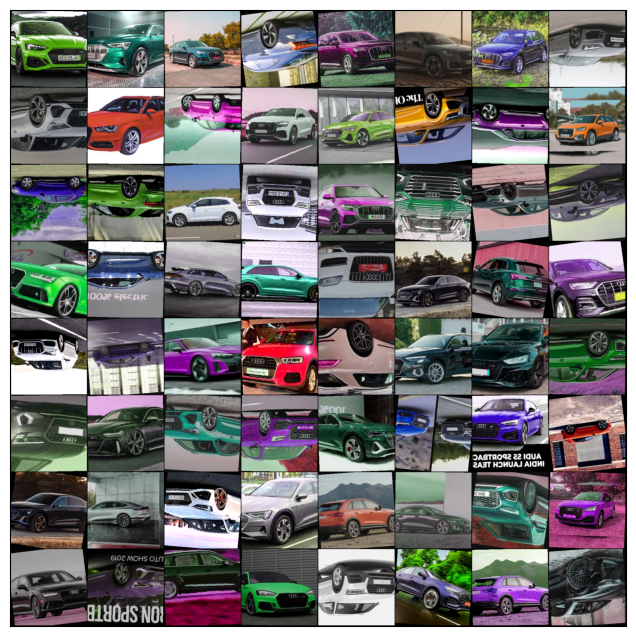

In [62]:
def denorm(img_tensors):
    return img_tensors * normstats[1][0] + normstats[0][0]

def show_batch(dl):#just to show one batch of our data
    for img, _ in dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(img[:64],nrow = 8).permute(1,2,0))
        break

def show_images(images):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]),ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(denorm(images.detach()[:64]),nrow = 8).permute(1,2,0))

dataload = DataLoader(augmented_dataset,batch_size,num_workers = 4,shuffle = True, pin_memory=True)#makes our data into batches
show_batch(dataload)

In [63]:
# GPU or CPU?
def find_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device('cpu')
    
device = find_default_device()
device

device(type='cpu')

In [64]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking=True)

In [67]:
class DataloaderDeviced():
    def __init__(self,data,device):
        self.data = data
        self.device = device
    def __iter__(self):
        for b in self.data:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.data)

In [68]:
dataload = DataloaderDeviced(dataload,device)

In [69]:
dataload

In [23]:
# Making Descriminator
descriminator = nn.Sequential(
    #input size being of 3 channels, 256x256
    nn.Conv2d(3, 32 ,kernel_size = 3, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #output size being of 32 channels, 128x128
    
    nn.Conv2d(32,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace = True),
    #out 128x32x32
    
    nn.Conv2d(128,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1,inplace = True),
    #out 256x16x16
    
    nn.Conv2d(256,512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace = True),
    #out 512x8x8
    
    nn.Conv2d(512,1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1,inplace = True),
    #out 1024x4x4
    
    nn.Conv2d(1024,1,kernel_size = 4,stride = 1, padding = 0, bias = False),
    #out 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid(),
    #final activation for T/F
)

#descriminator.load_state_dict(torch.load("../input/weights/discweights4.pth"))
descriminator = to_device(descriminator,device)
descriminator

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

In [25]:
# Making a Generator
latent_sz = 128
generator = nn.Sequential(
    #latent in 128x1x1
    nn.ConvTranspose2d(128,1024,kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1, inplace=True),
    #out 1024x4x4
    
    nn.ConvTranspose2d(1024,512,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.1, inplace=True),
    #out 512x8x8
    
    nn.ConvTranspose2d(512,256,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.1, inplace=True),
    #out 256x16x16
    
    nn.ConvTranspose2d(256,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    #out 128x32x32
    
    nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    #out 64x64x64
    
    nn.ConvTranspose2d(64,32,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    #out 32x128x128
    
    nn.ConvTranspose2d(32,3,kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    #out 3x256x256
    
)
#generator.load_state_dict(torch.load("../input/weights/genweights4.pth"))
generator

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1, inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1, inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.1, inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.1, inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


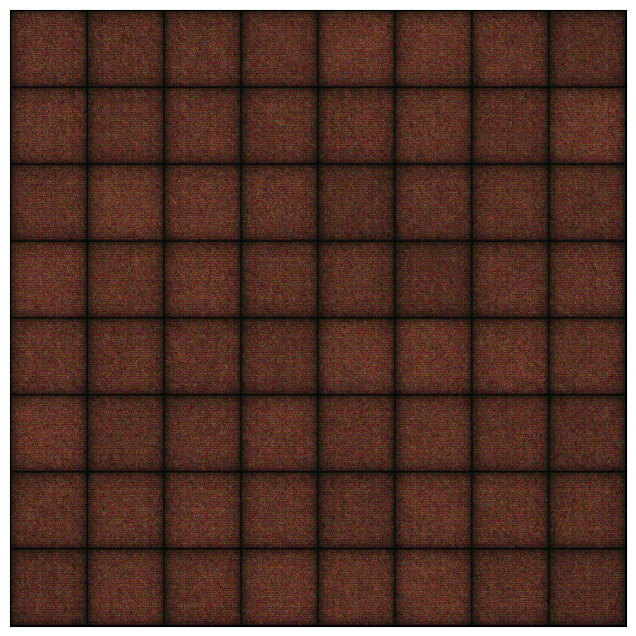

In [26]:
xb = torch.randn(batch_size,latent_sz,1,1,)
fake_images = generator(xb)
show_images(fake_images)
generator = to_device(generator,device)

In [27]:
# Training the discriminator
def train_discriminator(real_images,opt_d):
    
    opt_d.zero_grad()
    real_preds = descriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device = device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size,latent_sz,1,1, device = device)
    fake_images = generator(latent)
    
    fake_preds = descriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,device = device)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = fake_loss+real_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(),real_score,fake_score

In [29]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size,latent_sz, 1,1, device = device)
    images = generator(latent)
    
    targets = torch.ones(batch_size,1,device = device)
    score = descriminator(images)
    loss = F.binary_cross_entropy(score,targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [31]:
# Saving the generator images
import os
savedir = "gen"
os.makedirs(savedir, exist_ok = True)


In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}e1.png'.format(index+90)
    save_image(denorm(fake_images), os.path.join(savedir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [33]:
torch.manual_seed(64)
fixed_latent = torch.randn(batch_size, latent_sz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0090e1.png


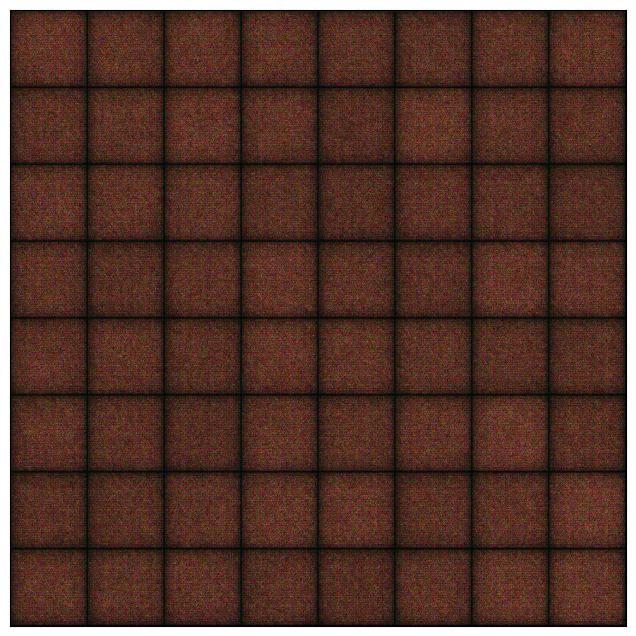

In [34]:
save_samples(0,fixed_latent)

In [37]:
# Fitting the data
def fit(epochs, lr, start_idx = 1):
    loss_d =[]
    loss_g = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(descriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for img, _ in dataload:
            
            loss, real_score, fake_score = train_discriminator(img, opt_d)
            lossg = train_generator(opt_g)
            
        loss_d.append(loss)
        loss_g.append(lossg)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss, lossg, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return loss_g,loss_d,real_scores,fake_scores

In [38]:
lr = 5e-4
epochs = 2
history = fit(epochs,lr)

Epoch [1/2], loss_g: 0.1116, loss_d: 7.1172, real_score: 0.8998, fake_score: 0.0012
Saving generated-images-0091e1.png
Epoch [2/2], loss_g: 0.4435, loss_d: 4.3244, real_score: 0.6921, fake_score: 0.0083
Saving generated-images-0092e1.png


In [39]:
#Visualizing our generator image
torch.manual_seed(94)
latent_test = torch.randn(1,latent_sz,1,1,device=device)
image = generator(latent_test)

In [40]:
image=to_device(image, torch.device("cpu"))
b=image[0].permute(1,2,0).detach().numpy()
b.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


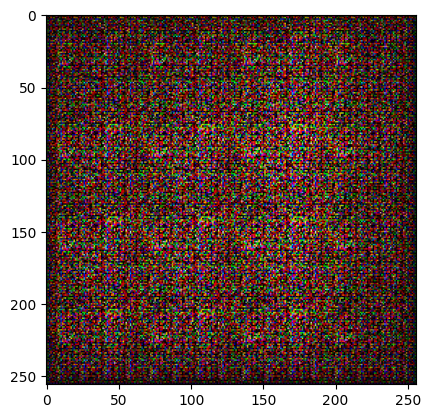

In [41]:
plt.imshow(b)